# Data Cleaning - Aggregated Airbnb Calendar

## Introduction

In the following notebook, I will be cleaning an aggregation of Airbnb calendar data. This data pertains to the San Francisco area and consists of calendar data from 9/2018 through 12/2019.

The aggregation source code can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/blob/master/Airbnb%20Raw%20Data%20Aggregation.ipynb)

Raw data can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Data/01_Raw/SF%20Airbnb%20Raw%20Data)

**Read in necessary libraries**

In [38]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

**Settings for Notebook**

In [39]:
#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Supress future warnings
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)

**Read in Data**

In [40]:
#Set path to get aggregated calendar data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\SF Airbnb Raw Data - Aggregated\12_26_2019_Calendar.csv'

#Set date columns for parsing
parse_dates = ['date']

#Read in calendar data
calendar = pd.read_csv(path, sep = ',', parse_dates=parse_dates,index_col=0, low_memory=False)

## Data Preview

In [41]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,$80.00,f,2019-04-03,187730,120.0,3.0,$80.00
1,$80.00,f,2019-04-04,187730,120.0,3.0,$80.00
2,$82.00,t,2019-04-05,187730,120.0,3.0,$82.00
3,$82.00,t,2019-04-06,187730,120.0,3.0,$82.00
4,$81.00,t,2019-04-07,187730,120.0,3.0,$81.00


In [42]:
#Print shape and dtypes of calendar data
print('Calendar data shape:',calendar.shape)
print('\nCalendar data types: \n',calendar.dtypes)

Calendar data shape: (20279225, 7)

Calendar data types: 
 adjusted_price            object
available                 object
date              datetime64[ns]
listing_id                 int64
maximum_nights           float64
minimum_nights           float64
price                     object
dtype: object


## Data Cleaning

**Data Type Conversion**

In [43]:
#Remove $ and , from price and adjusted price column
cols = ['adjusted_price', 'price']
calendar[cols]=calendar[cols].replace('[,$]','', regex=True)

#drop dups
calendar.drop_duplicates(inplace=True)

#Convert string to numeric
calendar[cols] =calendar[cols].swifter.apply(pd.to_numeric, errors='coerce')

#Replace 't' and 'f' in available column to True and False
calendar.available = calendar.available.swifter.apply(lambda x:  1 if x =='t' else 0)

#Correct data type for data column
calendar.date=pd.to_datetime(calendar.date)

In [44]:
calendar.groupby(['available', 'date'])['available'].count()

available  date      
0          2018-09-08    5596
           2018-09-09    5262
           2018-09-10    5310
           2018-09-11    5378
           2018-09-12    5422
                         ... 
1          2020-11-29    3350
           2020-11-30    3294
           2020-12-01    3296
           2020-12-02    3288
           2020-12-03      58
Name: available, Length: 1636, dtype: int64

**View calendar metrics**

In [45]:
# #Describe calendar data
# print(calendar.describe())
 
# #Print variance within calendar data
# print('\nCalendar variance: \n',calendar.var(axis=0))

**Missing Data**

In [46]:
#Capture total number of missing data per column
total = calendar.isnull().sum().sort_values(ascending=False)

#Calculate the % of missing data per column
percent = (calendar.isnull().sum()/calendar.isnull().count()).sort_values(ascending=False)

#Concatenate into a pd dataframe
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Missing Percent'])

#Format percentage  
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)

#View columns with > 10% of data missing
missing_data.loc[missing_data['Missing Percent'] > 10][:10]

,Total Missing,Missing Percent
adjusted_price,4771744,23.530209
minimum_nights,4770880,23.525948
maximum_nights,4770880,23.525948
price,2267393,11.180866


**Calendar data distributions**

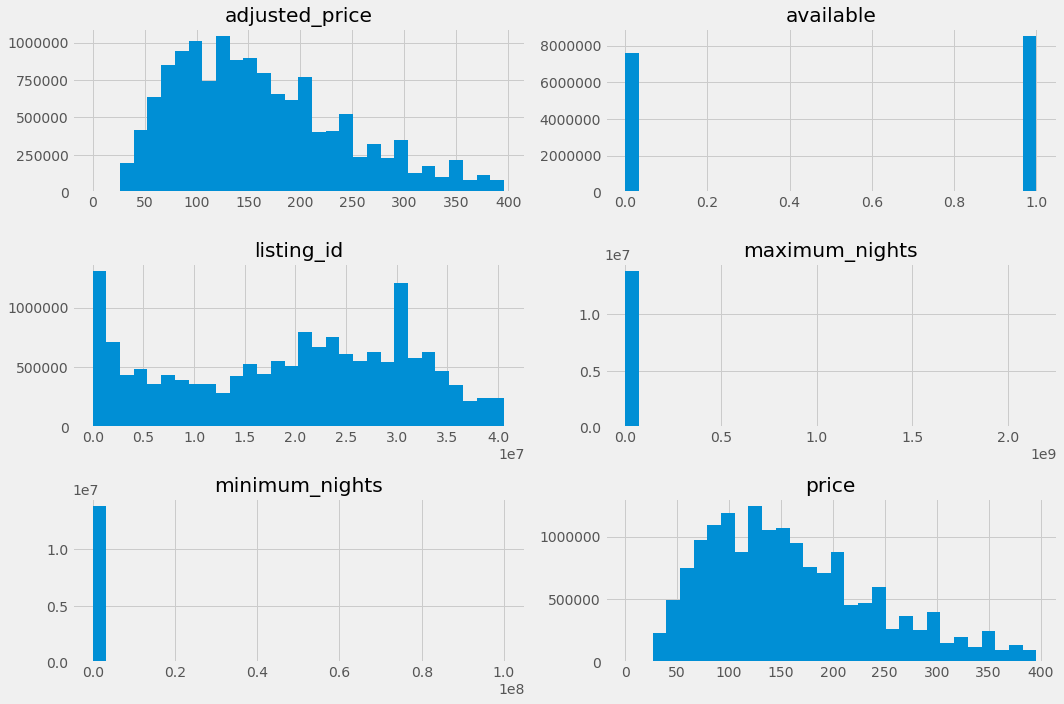

In [60]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Display distributions of calendar data
calendar.hist( figsize=(15,10), bins = 30, layout = (3,2));
plt.tight_layout()
plt.show()

#Set Path to write plot
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Output Files\Visualizations\Calendar Data Distributions'

#Save plot to png
#plt.savefig(path + '\Calendar Raw Data Distributions.png',bbox_inches = 'tight')

#### Price Outlier Removal

**Identify and remove outliers using IQR**

Removing outliers from price should normalize both price and adjusted_price columns.

In [48]:
#Calculate IQR of price
q25 = calendar['price'].quantile(0.25)
q75= calendar['price'].quantile(0.75)
iqr = q75 - q25

#Print percentiles
print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

#Calculate outlier cutoffs
cut_off =1.5 * iqr
lower, upper = q25 - cut_off, q75 + iqr

#Identify outliers
outliers = [x for x in calendar.price if x < lower or x > upper]
print("Number of outliers identified: {}".format(len(outliers)))

#Remove outliers
outliers_removed = [x for x in calendar.price if x >= lower and x <= upper]
print('Non-outlier observations: {}'.format(len(outliers_removed)))

#Update df
calendar = calendar[calendar.price.isin(outliers_removed)]

Percentiles: 25th=102.000, 75th=249.000 
IQR= 147.000
Number of outliers identified: 1869039
Non-outlier observations: 16142793


New calendar shape:  (16142793, 7)


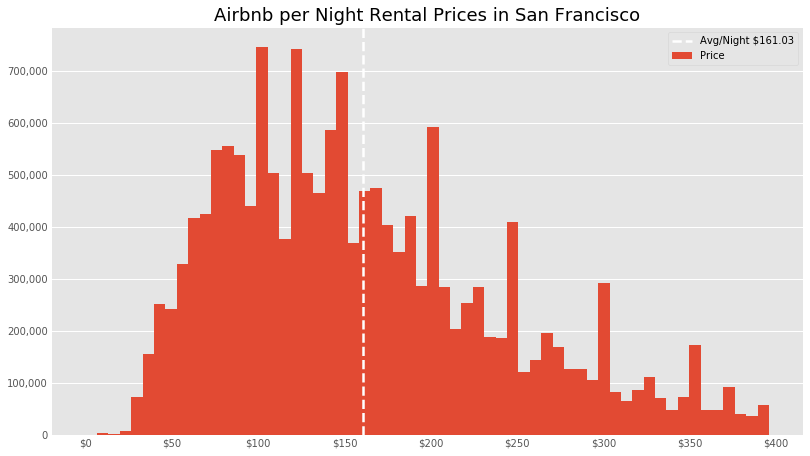

In [49]:
#Updated calendar Shape
print('New calendar shape: ', calendar.shape)

#Set ggplot plot style
plt.style.use('ggplot')

#Plot updated prices from calendar data
plot = calendar.price.plot(kind = 'hist', bins=60, figsize=(12,7), label = 'Price',
                   legend = True)

#Get plot object
ax = plt.gca()

#Capture mean
mean = np.mean(calendar.price)

#Plot mean and median to histogram
ax.axvline(mean, color='white', linestyle='dashed', linewidth=2.5, label = "Avg/Night ${:}".format(str(round(mean,2))))

#Format x-axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Format y ticks
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('')

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Set Title
ax.set_title('Airbnb per Night Rental Prices in San Francisco', fontweight= 'normal', fontsize = 18)

#Show legend
plt.legend(frameon = True, loc='upper right');

#Save plot to png
fig = plot.get_figure()
fig.savefig(path + '\Airbnb per Night Rental Prices in San Francisco.png',bbox_inches = 'tight')

In [59]:
(calendar.price.isna().sum()/calendar.price.sum()) * 100

0.0

In [51]:
# #Set path to write listings
# path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate\12_23_2019_Calendar_Cleaned.csv'

# #Write listings to path
# calendar.to_csv(path, sep=',')